# Modeling Stock Movement
Brian Bahmanyar

***

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import seaborn as sns

import sys
sys.path.append('./src/')
from plots import *

In [2]:
%matplotlib inline

In [3]:
tech = pd.read_csv('data/tech_bundle.csv', index_col=0)
tech.index = pd.to_datetime(tech.index)

Recall neither Facebook's and Apple's stock had an obvious autocorrelation structure in their adjusted daily close prices. Thus we conclude that these series follow a random walk.

It can be shown that the following holds: $\frac{y_t}{y_{t-1}} \sim LogN(\mu, \sigma^2)$, where $y_t$ represents the adjusted close price of a stock.

Notice below when we plot $\frac{y_t}{y_{t-1}}$ (daily return ratio) for Facebook's historical stock price the distibution we observe can be approximated by a log-normal distribution.

In [4]:
def get_daily_return_ratio(series):
    """
    Args: series (ndarray)----the time series to get the lagged return ratios
          window_size (int)---number of trading weeks to use
    Return: (ndarray) y(t)/y(t-1) over the weeks specified
    """

    return (series[1:]/series[:-1])

In [5]:
assert(tech.FB.count()-1 == len(get_daily_return_ratio(tech.FB.values)))
assert(tech.FB[1]/tech.FB[0] == get_daily_return_ratio(tech.FB.values)[0])

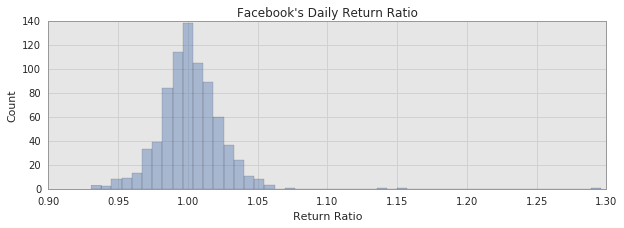

In [6]:
plt.figure(figsize=(10,3));
plt.title("Facebook's Daily Return Ratio");
plt.xlabel('Return Ratio');
plt.ylabel('Count');
sns.distplot(get_daily_return_ratio(tech['FB'].values), kde=False);

We will use Maximum Likelyhood Estimation to estimate the parameters of the distribution.

In [7]:
def neg_log_llh(theta, data):
    """
    Args theta (list)-----the params [mu, sigma**2]
         data (ndarray)---data points to be fit by log normal distribution
    Return: (double) negative log-likelihood for the log normal.
    """
    
    mu, sigma = theta[0], np.sqrt(theta[1])
    neg_log_llhs = np.log(data*sigma*np.sqrt(2*np.pi)) + ((np.log(data)-mu)**2/(2*(sigma**2))) 
    
    return neg_log_llhs.sum()

In [8]:
def mle_log_norm(data, init_theta=[1,1]):
    """
    Args: theta (list)-----the params [mu, sigma**2]
          data (ndarray)---data points to be fit by log normal distribution 
    Return: (list) mu, sigma**2 for fitted log normal params
    """
    
    fit = opt.minimize(neg_log_llh, init_theta, data, method='Nelder-Mead')
    
    return fit.x

In [9]:
fit = mle_log_norm(get_daily_return_ratio(tech['FB'].values))
fit

array([ 0.00173078,  0.00054006])

This tells us for Facebook: $\frac{y_t}{y_{t-1}} \sim LogN(0.0017, 0.00054)$

Lets vizualize what this theoretical distribution looks like:

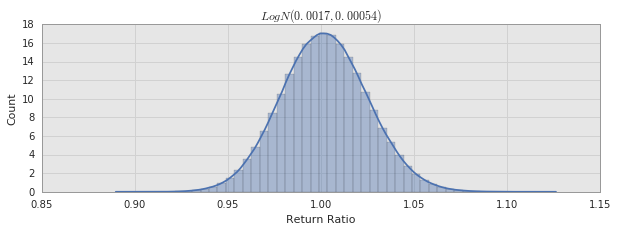

In [10]:
plt.figure(figsize=(10,3));
plt.title(r'$LogN(0.0017, 0.00054)$');
plt.xlabel('Return Ratio');
plt.ylabel('Count');
sns.distplot(np.random.lognormal(fit[0], np.sqrt(fit[1]), size=1000000));

Now that we are convinced that daily return ratios follow a log-normal distribution we can exploit this to forcast future days prices with a log normal random walk.

### Modeling Facebook's Daily Adjusted Close Prices

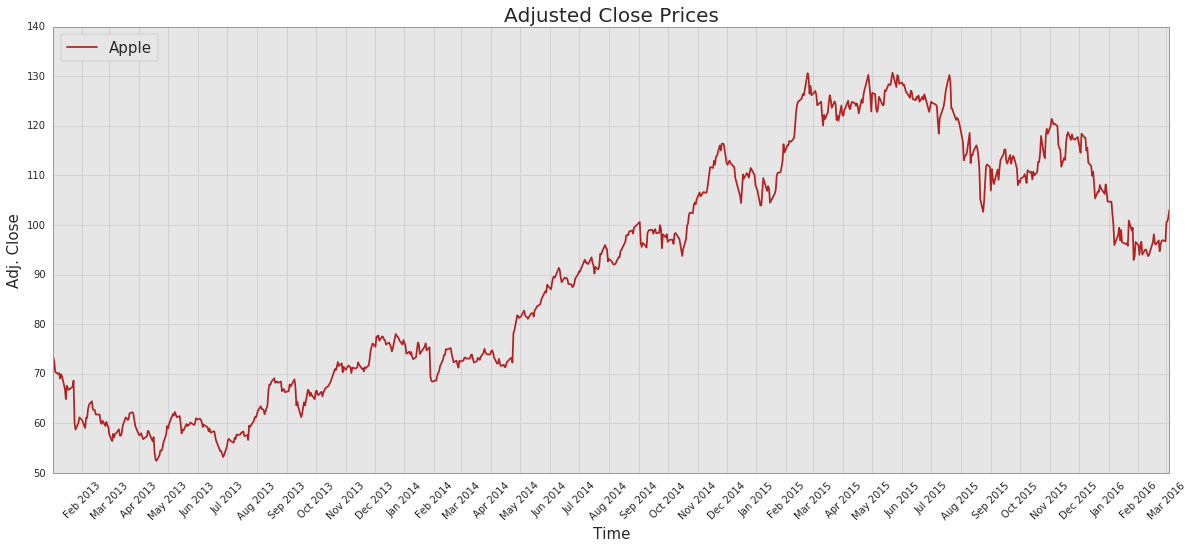

In [11]:
plot_stocks(tech.index, [tech['AAPL']], ['Apple'], label_annually=False)

Lets simulate this random walk and see what the movement looks like.

In [12]:
def simulate_random_walk(series, window_size=10, ahead=50):
    """
    Args: series (ndarray)----time series to use
          window_size (int)---number of trading weeks to use for log normal estimation
          ahead (int)---------how many days do you want to forcast head for
    Return (ndarray): simulated future price
    """
    
    forcasts = np.zeros(ahead)
    window = series[-((window_size*5)+1):].values

    for step in range(ahead):
        mu, sigma2 = mle_log_norm( get_daily_return_ratio(window) )
        forcast = window[-1]*np.random.lognormal(mu, np.sqrt(sigma2), 1)
        forcasts[step] = forcast
        window = np.roll(window, -1)
        window[-1] = forcast
    
    return forcasts

In [13]:
def plot_simulated_forcast(series, window, ahead, train_on=None, n=10):
    """
    Plots Simulated Forcast and Original Series
    
    Args: series (ndarray)---time series for which to forcast
          window (int)-------window size for MLE of log normal
          ahead (int)--------number of days to forcast for
          train_on (int)-----optional, number of days from series to use to forcast
          n (int)------------number of simulations to plot
    Returns: None, plots inline
    """ 

    if not train_on:
        train_on = series.count()
    
    train_x_space = np.arange(0,series.count())
    test_x_space = np.arange(train_on, train_on+ahead)
    
    plt.figure(figsize=(15,6));
    plt.plot(train_x_space, series)
    for _ in range(n):
        walk = simulate_random_walk(series[:train_on], window, ahead)
        plt.plot(test_x_space, walk, linestyle='-', color='salmon', alpha=0.7)
    
    plt.xlabel('Time Index (Days)');
    plt.ylabel('Adjusted Close Price');
    plt.title('Simulated Log Normal Random Walk Forcast');

Here we are using data from the first 650 prices and a daily return window of 100 days to predict Facebook's price 135 days into the future. We can notice a general positive slope in all our predictions (in pink). However when we approximate our forcast we will want to employ some math to calculate an expected value and variance at each step.

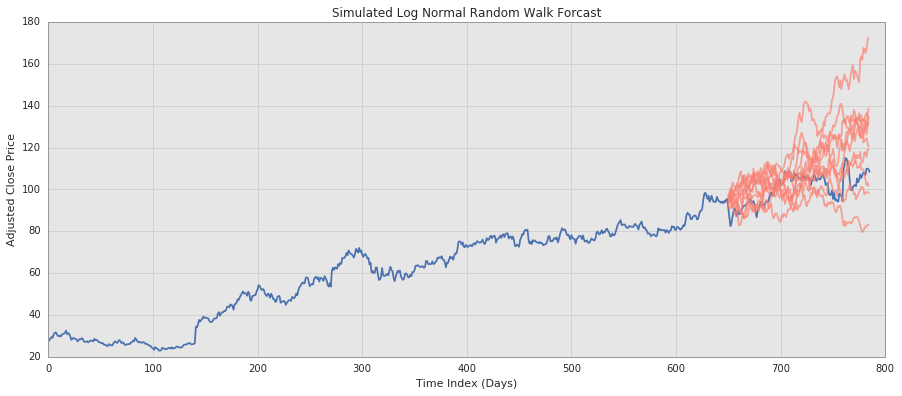

In [14]:
plot_simulated_forcast(tech['FB'], window=100, ahead=135, train_on=650, n=10);

$$ \frac{y_t}{y_{t-1}} \sim LogN(\mu, \sigma^2) \Rightarrow \hat{y_t} = y_{t-1} \cdot \mathrm{E}[LogN(\mu, \sigma^2)] $$  

$$ Given: \mathrm{E}[LogN(\mu, \sigma^2)] = e^{\mu+\sigma^2/2} $$  

$$\hat{y_t} = y_{t-1} \cdot e^{\mu+\sigma^2/2} \Rightarrow \hat{y_{t+k}} = y_{t+(k-1)} \cdot e^{\mu+\sigma^2/2}$$  

$$ \hat{y_{t+k}} = y_{t+(k-1)} \cdot \mathrm{E}[LogN(\mu, \sigma^2)] $$  

$$ \Rightarrow \hat{y_{t+k}} = y_t \cdot \mathrm{E}[LogN(\mu, \sigma^2)]^k $$

We can use this model to predict in the future. Processes that approximatley follow this model are called log normal random walks.

$\mathrm{E}[LogN(\mu, \sigma^2)] = e^{\mu+\sigma^2/2}$ as a python function below:

In [15]:
def get_expected_value(mu, sigma2):
    """
    Returns expected value for log normal with params mu, sigma2
    
    Args: mu (float)-------parameter mu
          sigma2 (float)---parameter sigma squared
    Returns: expected value (float) of the log normal
    """
    
    return (np.exp((mu+sigma2)/2))

$\mathrm{V}[LogN(\mu, \sigma^2)] = (e^{\sigma^2}\!\!-1) e^{2\mu+\sigma^2}$ as a python function below: 

In [16]:
def get_variance(mu, sigma2):
    """
    Returns variance for log normal with params mu, sigma2
    
    Args: mu (float)-------parameter mu
          sigma2 (float)---parameter sigma squared
    Returns: variance (float) of the log normal
    """
    
    return (np.exp(sigma2)-1)*np.exp((2*mu)+sigma2)

The K step variance gets a little tricky. The derivation is below:

$$ Z \sim \mathrm{E}[LogN(\mu, \sigma^2)] $$

$$Given: \mathrm{V}[X] = \mathrm{E}[X^2] - \mathrm{E}[X]^2$$

$$ \mathrm{V}[y_{t+k}|y_t] = \mathrm{E}[y^2_{t+k}|y_t] - \mathrm{E}[y_{t+k}|y_t]^2 $$

$$ \mathrm{V}[y_{t+k}|y_t] = y^2_t \cdot \mathrm{E}[Z^2_{t+1}]^k - y^2_t \cdot \mathrm{E}[Z_{t+1}]^{2k} $$

$$ \mathrm{V}[y_{t+k}|y_t] = y^2_t \cdot [\mathrm{E}[Z^2_{t+1}]^k - \cdot \mathrm{E}[Z_{t+1}]^{2k}] $$ 

$$ \mathrm{V}[y_{t+k}|y_t] = y^2_t \cdot [(\mathrm{V}[Z_{t+1}] + \mathrm{E}[Z_{t+1}]^{2})^k - \cdot \mathrm{E}[Z_{t+1}]^{2k}] $$

In [17]:
def get_k_step_variance(mu, sigma2, k, yt):
    """
    Returns a k step ahead variance for log normal with params mu, sigma2
    
    Args: mu (float)-------parameter mu
          sigma2 (float)---parameter sigma squared
          k (int)----------number of steps ahead
          yt (float)-------price at time t (end of sample)
    Returns: variance (float) of the log normal
    """
    
    return (yt**2) * ((get_variance(mu, sigma2) + get_expected_value(mu, sigma2)**2)**k - (get_expected_value(mu, sigma2)**2)**k)

We can now use these functions to create an expected forcast.

In [18]:
def get_expected_walk(series, window_size=10, ahead=50):
    """
    Args: series (ndarray)----time series to use
          window_size (int)---number of trading weeks to use for log normal estimation
          ahead (int)---------how many days do you want to forcast head for
    Return (ndarray): simulated future price
    """
    E_Xs = np.zeros(ahead)
    V_Xs = np.zeros(ahead)
    yt = series[-1]
    last_price = series[-1]
    window = series[-((window_size*5)+1):].values

    for step in range(ahead):
        mu, sigma2 = mle_log_norm( get_daily_return_ratio(window) )
        E_Xs[step] = last_price * get_expected_value(mu, sigma2)
        V_Xs[step] = get_k_step_variance(mu, sigma2, step+1, yt)
        last_price = last_price * get_expected_value(mu, sigma2)

    return E_Xs, V_Xs

In [19]:
def plot_expected_forcast(series, window, ahead, train_on=None, error=2):
    """
    Plots Expected Forcast and Original Series
    
    Args: series (ndarray)---time series for which to forcast
          window (int)-------window size for MLE of log normal
          ahead (int)--------number of days to forcast for
          train_on (int)-----optional, number of days from series to use to forcast
          error (int)--------number of standard devations to use for confidence bands
    Returns: None, plots inline
    """
    
    if not train_on:
        train_on = series.count()
    
    mu, sigma2 = get_expected_walk(series[:train_on], window, ahead)
    low_bound = mu-(error*np.sqrt(sigma2))
    high_bound = mu+(error*np.sqrt(sigma2))
    
    train_x_space = np.arange(0,series.count())
    test_x_space = np.arange(train_on, train_on+ahead)
    
    plt.figure(figsize=(15,6));
    plt.plot(train_x_space, series);
    plt.plot(test_x_space, mu, 'maroon');
    plt.plot(test_x_space, high_bound, 'olive');
    plt.plot(test_x_space, low_bound, 'olive');
    plt.fill_between(test_x_space, low_bound, high_bound, alpha=0.2, color='y')
    
    plt.xlabel('Time Index (Days)');
    plt.ylabel('Adjusted Close Price');
    plt.title('Expected Log Normal Random Walk Forcast');

Below we use the equations above to create an expected forcast using the first 635 data points and a return ratio window of 30 days. We can see that the forcast is doing a great job. The yellow are the 95% confidence interval bands which incease as we get farther from our sample.

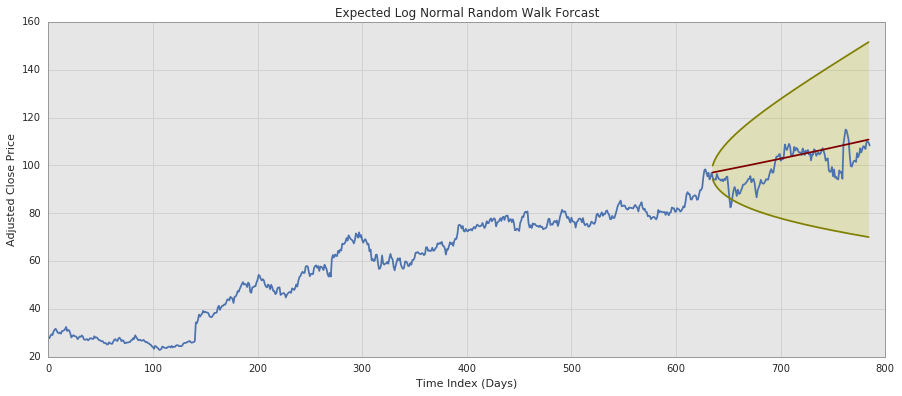

In [20]:
plot_expected_forcast(tech.FB, 30, 150, 635, error=2)

#### Please ignore, this was an ARMA(p,d,q) I chose to remove

In [21]:
# def acf_objective(order, series):
#     try:
#         model = arima_model.ARIMA(series, order).fit()
#         return model.aic
#     except:
#         return np.inf # if the model is not stationary return inf

In [22]:
# def get_optimal_arima(series, cost):
    
#     grid = (slice(0, 4, 1), slice(1,2,1), slice(0, 4, 1))
#     orders = brute(cost, grid, args=(series,), finish=None)
#     orders = [int(order) for order in orders]
    
#     arima = arima_model.ARIMA(series, order=orders).fit()
#     print({'p':orders[0], 'd':orders[1], 'q':orders[2]})
    
#     return arima

In [23]:
# def fit_arima(series, p, d, q):
#     model = arima_model.ARIMA(series, [p,d,q], method='css').fit()
#     return model.aic

In [24]:
# fit = opt.minimize(hat, -2, (a, b))

In [25]:
# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(np.arange(1,787), tech.FB.values)
# fig = arima.plot_predict(649, 785, dynamic=True, ax=ax,
#                          plot_insample=False)